<b> Final Project </b>
===

Introduction
===

In [ ]:
'''
=================================================
Final Project

Nama  : Sam & Edo aka 2 survivors
Batch : BSD-10

Proyek ini dibuat untuk menganalisis data pengiriman untuk memprediksi keterlambatan pengiriman.
=================================================
'''

'\n=================================================\nFinal Project\n\nNama  : Sam & Edo aka 2 survivors\nBatch : BSD-10\n\nThis program will prepare, process, and make predictions on apartment rental prices.\n=================================================\n'

## Background

In the rapidly growing e-commerce industry, on-time delivery is a critical factor in customer satisfaction and business success. Delays in shipping can lead to negative reviews, increased return rates, and loss of customer trust, ultimately impacting revenue and brand reputation. By analyzing historical shipping data with machine learning, we can predict delays before they happen and take corrective actions and identify key factors such as shipping mode, warehouse block, etc that's contributing to delays. This project aims to leverage data science to minimize delivery delays, enhancing both customer satisfaction and operational efficiency in e-commerce.

## Problem Statement

Within the next two weeks, we will build a classification model that, on a 20% test split of 10,999 shipping transactions, can detect at least 85% of all delayed shipments (delay-class recall ≥ 85%) with accuracy ≥ 85%, using the available features (product cost, weight, customer service calls, prior purchases, discounts, etc.), supported by data quality validation (Great Expectations) and a pipeline that can be saved and deployed


## Problem Exploratory Questions

1. How big is the baseline delay (class balance)?
2. Which warehouse is most at risk of delays?
3. Which mode represents the highest risk, and how large is the risk differential to warrant prioritizing it for SLA/vendor negotiation or rerouting?
4. Of all late deliveries, what proportion is contributed by each shipping mode (Flight/Road/Ship), and which mode contributes the largest portion of delay incidents?
5. Which product importance segment is most vulnerable (High/Medium/Low) to delays?
6. Does package weight affect delays?
7. How does the discount affect the late rate?
8. Does the number of calls to CS correlate with delays?



Preparation
===

## Import Libraries

In [2]:
# data manipulation and mathematics operation
import pandas as pd
import numpy as np

# stats library
from scipy import stats

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta

# stats library
from scipy import stats
from scipy.stats import zscore
from scipy.stats import skew
from scipy.stats import pearsonr

# data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from feature_engine.outliers import Winsorizer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# learn
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

# warning
import warnings
warnings.filterwarnings('ignore') #turn off warning

# counter
from collections import Counter

# model saving
import pickle

# great expectations
import great_expectations as ge
from great_expectations.data_context import FileDataContext

## Data Introduction

We are going to use a dataset from Kaggle.com

Here are some information below,

Description: The dataset raw_data.csv contains information about E-Commerce Shipping Data

| Columns' names | Dtype | Description |
|-----|------|--------|
| id | int |  ID Number of Customers|
| warehouse_block | str | The Company have big Warehouse which is divided in to block in alphabets|
| mode_of_shipment | str | The Company Ships the products in multiple way such as Ship, Flight and Road|
| customer_care_calls | int |  The number of calls made from enquiry for enquiry of the shipment|
| customer_rating | int | The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).|
| cost_of_the_product | int | Cost of the Product in US Dollars|
| prior_purchases | int | The Number of Prior Purchase|
| product_importance | str | The company has categorized the product in the various parameter such as low, medium, high|
| gender | str | Male and Female|
| discount_offered | int | Discount offered on that specific product|
| weight_in_gms  | int | It is the weight in grams|
| reached_on_time | int | It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time|



In [3]:
# display max
pd.set_option('display.max_columns', None)

# load data
rw = pd.read_csv('raw_data.csv')

# data info
rw.info()

# show the first 3 rows
rw.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1


### Confusion Matrix Definition

Target Variable / y / Actual Labels:
- Positive Class (1): Shipment is delayed.

- Negative Class (0): Shipment is on-time.

Model Prediction / x / Predicted Labels:
- Positive Prediction (1): The model predicts the shipment will be delayed.

- Negative Prediction (0): The model predicts the shipment will be on-time.

Matrix:

- True Positives (TP): Shipments correctly predicted as delayed.

- False Positives (FP): Shipments incorrectly flagged as delayed (actually: on-time).

- True Negatives (TN): Shipments correctly predicted as on-time.

- False Negatives (FN): Shipments incorrectly predicted as on-time (actually: delayed).

The key goal is to minimize false negatives (failing to predict delays that actually occur). This is because missing a delay (high false negatives) is more costly than falsely predicting a delay (false positives).

### Summary

Details for the dataset:

The dataset has 10999 entries with 12 columns. There are 6 categoricals,

- **Categorical Nominal,**
 
  These columns have categories without any inherent order or ranking:

    - warehouse_block: A-F, with no specific order.

    - mode_of_shipment: Ship, Road, and Flight.

    - gender: Male and Female.

- **Categorical Ordinal,**

  These columns have categories that inherent order or ranking:

    - product_importance: low, medium, and high, which represents a clear order of importance.

    - customer_rating: An ordinal scale from 1 to 5, 1 as very bad and 5 as excellent.

    - reached_on_time: A binary outcome (0 or 1), 0: no & 1: yes.

and 6 numerical data,

- **Numerical Discrete,**

  These columns represent countable whole numbers or specific counts:

    - id: A unique identifier for each entry.

    - customer_care_calls: The count of calls made by the customer.

    - prior_purchases: The count of prior purchases made by the customer.

    - discount_offered: The integer percentage discount offered.

- **Numerical Continuous,**

  These columns represent measurements that can take any value within a range:

    - cost_of_the_product: A measurement of the cost of the product.

    - weight_in_gms: A measurement of the weight in grams.

Overall, it has 6 categoricals Dtype and 6 numericals Dtype with 4 strings and 8 integers

## Data Awareness

Here we want to look into the data to observe what are we going to work with, does it has duplicates?, how many missing values?, is there any unique missing values?, etc.


### Evaluate Duplicates

In [4]:
# check for duplicates
print(f'Number of duplicates: {rw.duplicated().sum()}')

Number of duplicates: 0


### Evaluate Missing Values

In [5]:
# check for NaN values in each columns
nan_count = rw.isnull().sum()

print("Number of NaN values per column:")
print(nan_count)

Number of NaN values per column:
ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64


### Evaluate specific value of string "NaN"

In [6]:
# check for the string 'NaN' in each column
nan_in_string_counts = {}
for col in rw.columns:
    if rw[col].dtype == 'object':
        count = rw[col].astype(str).str.contains('NaN', na=False).sum()
        if count > 0:
            nan_in_string_counts[col] = count
            
if nan_in_string_counts:
    print("Columns with 'NaN' as a string:")
    for col, count in nan_in_string_counts.items():
        print(f"Column '{col}': {count} occurrences")
else:
    print("No columns contain the string 'NaN'.")

No columns contain the string 'NaN'.


### Evaluate the count of '0' on 'Reached_on.Time_Y.N' column

In [7]:
# evaluate the count of '0'
zero_count = rw[rw['Reached.on.Time_Y.N'] == 0].shape[0]

print(f"The value '0' appears {zero_count} times in the 'Reached.on.Time_Y.N' column.")

The value '0' appears 4436 times in the 'Reached.on.Time_Y.N' column.


### Summary

It seems that there are no duplicates and missing values that needs to work on in the making of the airflow. But the names of each column, it doesn't aligned with the standardization of names in the column. We will work on this with the query through PostgreSQL via Docker.

Data Engineering
===

## Query on PostgreSQL

### DDL & DML

CREATE TABLE IF NOT EXISTS raw_data (
  id INTEGER,
  warehouse_block VARCHAR(255),
  mode_of_shipment VARCHAR(255),
  customer_care_calls INTEGER,
  customer_rating INTEGER,
  cost_of_the_product INTEGER,
  prior_purchases INTEGER,
  product_importance VARCHAR(255),
  gender VARCHAR(255),
  discount_offered INTEGER,
  weight_in_gms INTEGER,
  reached_on_time INTEGER
);

/*
NOTE: Here we make all the column names align with the rules.
*/

/*
DML for inserting data
*/
COPY raw_data(id, warehouse_block, mode_of_shipment, customer_care_calls, customer_rating, cost_of_the_product, prior_purchases, product_importance, gender, discount_offered, weight_in_gms, reached_on_time)
FROM '/mnt/data/raw_data.csv'
DELIMITER ','
CSV HEADER;

## Airflow

We are making it on final_project_DAG.py which generates cleaned_data.csv

## Great Expectations

### Data loading

In [8]:
context = FileDataContext.create(project_root_dir='.')

In [9]:
# Give a name to a Datasource. This name must be unique between Datasources.
datasource_name = 'e-commerce-datasources'
datasource = context.sources.add_pandas(datasource_name)

# Give a name to a data asset
asset_name = 'e-commerce'
path_to_data = 'cleaned_data.csv'
asset = datasource.add_csv_asset(asset_name, filepath_or_buffer=path_to_data)

# Build batch request
batch_request = asset.build_batch_request()

In [10]:
# Creat an expectation suite
expectation_suite_name = 'expectation-clean-dataset'
context.add_or_update_expectation_suite(expectation_suite_name)

# Create a validator using above expectation suite
validator = context.get_validator(
    batch_request = batch_request,
    expectation_suite_name = expectation_suite_name
)

# Check the validator
validator.head()

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

,id,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,gender,discount_offered,weight_in_gms,reached_on_time
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


### Expectation 1: id should be unique

In [11]:
# Expectation 1
validator.expect_column_values_to_be_unique(column="id")

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "result": {
    "element_count": 10999,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### Expectation 2: cost_of_the_product should be between reasonable values ($96 and $360)

In [12]:
# Expectation 2
validator.expect_column_values_to_be_between(
    "cost_of_the_product", min_value=96, max_value=310
)

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "result": {
    "element_count": 10999,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### Expectation 3: mode_of_shipment values should be in a known set

In [13]:
# Expectation 3
validator.expect_column_values_to_be_in_set(
    "mode_of_shipment", ["Flight", "Ship", "Road"]
)

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "result": {
    "element_count": 10999,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### Expectation 4: weight_in_gms should be in numeric

In [14]:
# Expectation 4
validator.expect_column_values_to_be_of_type("weight_in_gms", "int")

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "success": true,
  "result": {
    "observed_value": "int64"
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### Expectation 5: customer_care_calls to exist

In [15]:
# Expectation 5
validator.expect_column_to_exist("customer_care_calls")

Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

{
  "success": true,
  "result": {},
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### Expectation 6: No null values in any column

In [16]:
# Expectation 6
columns = validator.columns()

for column in columns:
    validator.expect_column_values_to_not_be_null(column)

Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

### Expectation 7: Validate gender values are only M or F

In [17]:
# Expectation 7
validator.expect_column_values_to_match_regex(
    "gender", "^[MF]$"
)

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "result": {
    "element_count": 10999,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### Expectation 8: Value counts to equal exactly 5 distinct for customer ratings

In [18]:
# Expectation 8
validator.expect_column_distinct_values_to_equal_set(
    "customer_rating", {1, 2, 3, 4, 5}
)

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

{
  "success": true,
  "result": {
    "observed_value": [
      1,
      2,
      3,
      4,
      5
    ],
    "details": {
      "value_counts": [
        {
          "value": 1,
          "count": 2235
        },
        {
          "value": 2,
          "count": 2165
        },
        {
          "value": 3,
          "count": 2239
        },
        {
          "value": 4,
          "count": 2189
        },
        {
          "value": 5,
          "count": 2171
        }
      ]
    }
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### Summary

All 8 Expectations are met. Now we move to Exploratory Data Analysis (EDA)

Load the Data for Data Analyst and Data Scientist
===

In [19]:
# display max
pd.set_option('display.max_columns', None)

# load data
df = pd.read_csv('cleaned_data.csv')

# data info
df.info()

# show the first 3 rows
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   10999 non-null  int64 
 1   warehouse_block      10999 non-null  object
 2   mode_of_shipment     10999 non-null  object
 3   customer_care_calls  10999 non-null  int64 
 4   customer_rating      10999 non-null  int64 
 5   cost_of_the_product  10999 non-null  int64 
 6   prior_purchases      10999 non-null  int64 
 7   product_importance   10999 non-null  object
 8   gender               10999 non-null  object
 9   discount_offered     10999 non-null  int64 
 10  weight_in_gms        10999 non-null  int64 
 11  reached_on_time      10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


,id,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,gender,discount_offered,weight_in_gms,reached_on_time
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1


Data Analyst
===

## Analyzation

### Exploratory Data Analysis (EDA)

In [20]:
# Make sure the target column exists
assert "reached_on_time" in df.columns, "column 'reached_on_time' not found."

# Target normalization: 1 = Late (late), 0 = On Time (on time)
# Original dataset: 1 = on-time, 0 = late
df["Late"] = 1 - df["reached_on_time"]

# Safe casting for numeric columns to be binned
for col in ["weight_in_gms", "discount_offered", "customer_care_calls"]: 
    if col in df.columns: 
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Helper: rate function
def late_rate_by(col): 
    g = (df 
        .groupby(col, dropna=False)["Late"] 
        .agg(["size", "mean"]) 
        .reset_index() 
        .rename(columns={"size": "records", "mean": "late_rate"}))
    return g

#### 1. How big is the baseline delay (class balance)?

##### Bar Chart

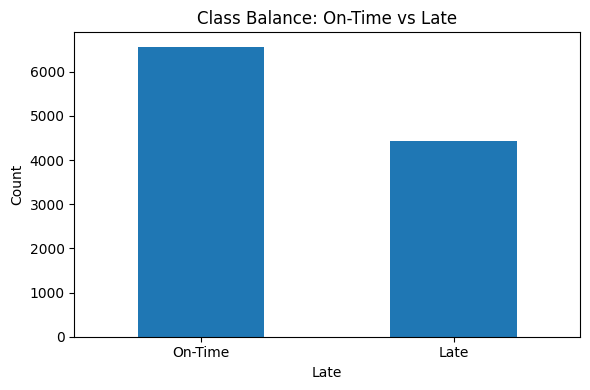

Overall Late Rate: 0.4033


In [21]:
# 1) Class Balance: On-Time vs Late
counts = df["Late"].map({0: "On-Time", 1: "Late"}).value_counts().reindex(["On-Time", "Late"])
plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Class Balance: On-Time vs Late")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

overall_late_rate = df["Late"].mean()
print(f"Overall Late Rate: {overall_late_rate:.4f}")

##### Summary

The overall late rate is around 40.33%, meaning nearly 4 out of 10 shipments are in SLA violation, significant enough to warrant immediate prioritization. The impact: potentially high compensation, complaint, and return costs. Initial recommendation: set a reduction target (e.g., -10% in a quarter) and establish weekly monitoring to quickly identify trends.

#### 2. Which warehouse is most at risk of delays?

##### Horizontal Bar Plot

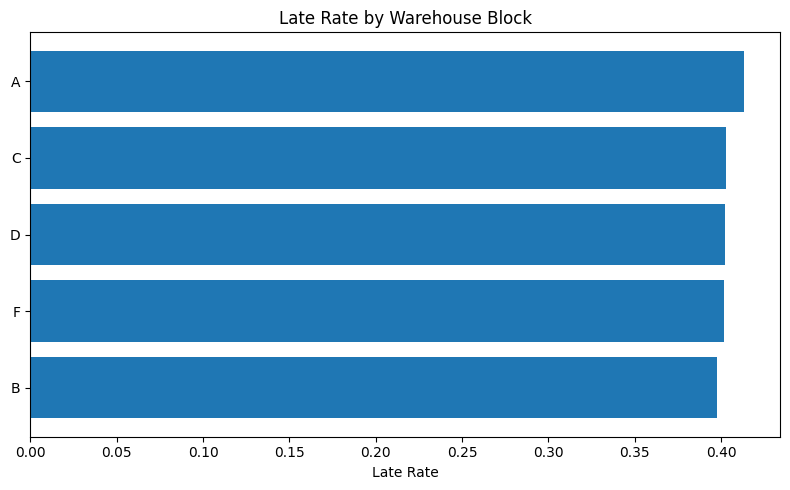

,warehouse_block,records,late_rate
0,A,1833,0.413530
2,C,1833,0.403164
3,D,1834,0.402399
4,F,3666,0.401528
1,B,1833,0.397709


In [22]:
# 2) Late Rate by Warehouse (Horizontal Bar)
assert "warehouse_block" in df.columns, "Column 'warehouse_block' not found."
wh = late_rate_by("warehouse_block").sort_values("late_rate", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(wh["warehouse_block"].astype(str), wh["late_rate"])
plt.gca().invert_yaxis()
plt.title("Late Rate by Warehouse Block")
plt.xlabel("Late Rate")
plt.tight_layout()
plt.show()

wh.head(10)

##### Summary

Warehouses A (41.35%) and C (40.32%) exhibit the highest risk compared to F (40.15%) and B (39.77%). This indicates potential capacity, cut-off scheduling, or handling issues at certain outbound points. Improvement areas include auditing the A/C process, adding sorting/pick-pack slots during peak hours, and testing load reallocation to more stable-performing warehouses.

#### 3. Which mode represents the highest risk, and how large is the risk differential to warrant prioritizing it for SLA/vendor negotiation or rerouting?

##### Bar Chart

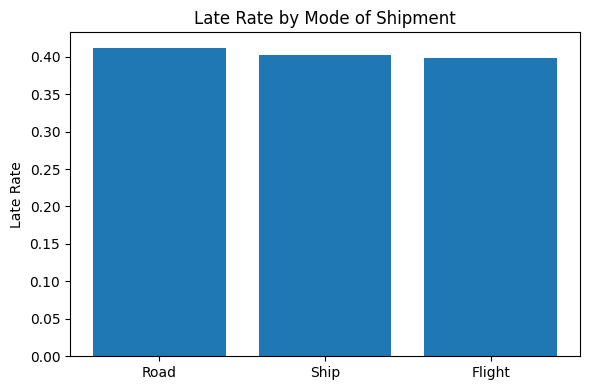

,mode_of_shipment,records,late_rate
1,Road,1760,0.411932
2,Ship,7462,0.402439
0,Flight,1777,0.398424


In [23]:
# 3) Late Rate by Mode of Shipment (Vertical Bar)
assert "mode_of_shipment" in df.columns, "Column 'mode_of_shipment' not found."
mode = late_rate_by("mode_of_shipment").sort_values("late_rate", ascending=False)

plt.figure(figsize=(6,4))
plt.bar(mode["mode_of_shipment"].astype(str), mode["late_rate"])
plt.title("Late Rate by Mode of Shipment")
plt.ylabel("Late Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

mode

##### Summary

Road has the highest risk (41.19%), while Flight has the lowest (39.84%), indicating differences in SLA meeting capabilities between modes/vendors. Route risky routes or prioritize shipments to historically more reliable modes, and negotiate Road SLAs/vendors (time buffers, carrier capacity, or alternative routes).

#### 4. Of all late deliveries, what proportion is contributed by each shipping mode (Flight/Road/Ship), and which mode contributes the largest portion of delay incidents?

##### Pie Chart

  mode_of_shipment  late_count  share_pct
2             Ship        3003      67.70
1             Road         725      16.34
0           Flight         708      15.96


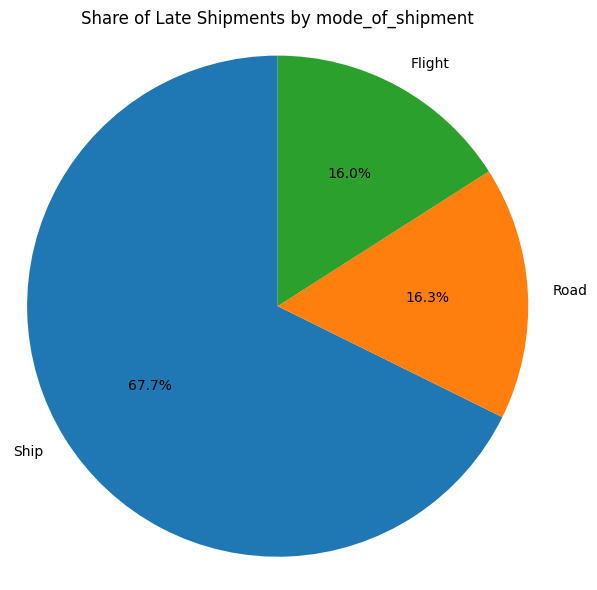

In [24]:
# Normalize target: 1 = late
df["Late"] = 1 - df["reached_on_time"]

# Composition dimensions
dim = "mode_of_shipment"

# Subset only latecomers
late_df = df[df["Late"] == 1].copy()

# Composition aggregation
comp = (late_df.groupby(dim)["Late"] 
    .size() 
    .reset_index(name="late_count") 
    .sort_values("late_count", ascending=False))
comp["share_pct"] = (comp["late_count"] / comp["late_count"].sum() * 100).round(2)
print(comp)

# Pie plots
plt.figure(figsize=(6,6))
plt.pie(comp["late_count"], labels=comp[dim].astype(str), autopct="%1.1f%%", startangle=90)
plt.title(f"Share of Late Shipments by {dim}")
plt.axis("equal")
plt.tight_layout()
plt.show()

##### Summary

Of all late shipments, the largest portion came from Ship, at 67.7%, followed by Road at 16.3% and Flight at 16.0%. This means that nearly two-thirds of late incidents occurred in the Ship mode. This shows that while Road has the highest relative late rate, the combination of volume and risk makes Ship the primary contributor to the number of late cases. For the fastest impact on reducing total delays, prioritize improvements in Ship lanes: audit carrier performance, optimize linehaul/port schedules, increase capacity buffers, and revise the cut-off for warehouses supplying Ship; then, implement targeted improvements in Road as the second step.

#### 5. Which product importance segment is most vulnerable (High/Medium/Low) to delays?

##### Bar Chart

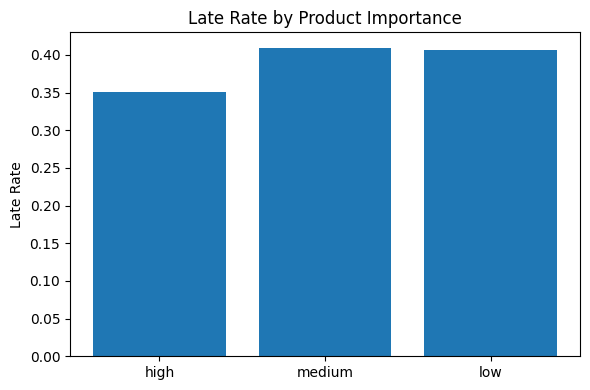

,product_importance,records,late_rate,late_rate_pct
0,high,948,0.350211,35.02
1,medium,4754,0.409550,40.95
2,low,5297,0.407212,40.72


In [25]:
# 5) Late Rate by Product Importance (Bar, urut: High > Medium > Low bila tersedia)
assert "product_importance" in df.columns, "Column 'product_importance' not found."
imp = late_rate_by("product_importance")

# Paksa urutan bila label tersedia
order = ["high", "medium", "low", "High", "Medium", "Low"]
present = [o for o in order if o in imp["product_importance"].astype(str).tolist()]
if present:
    imp = imp.set_index("product_importance").loc[present].reset_index()

plt.figure(figsize=(6,4))
plt.bar(imp["product_importance"].astype(str), imp["late_rate"])
plt.title("Late Rate by Product Importance")
plt.ylabel("Late Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

imp.assign(late_rate_pct=(imp["late_rate"]*100).round(2))

##### Summary

The Medium (40.95%) and Low (40.72%) segments performed worse than High (35.02%), suggesting that prioritization mechanisms (fast lanes, earlier cutoff) are already working well for High. Extending similar policies to Medium/Low (e.g., limited priority lanes during peak traffic) has the potential to reduce delays while maintaining customer experience.

#### 6. Does package weight affect delays?

##### Line Chart

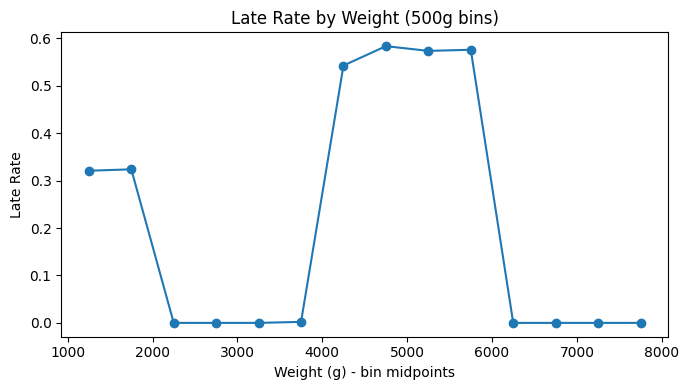

Slope (late vs weight): -0.000014


,weight_bin,records,late_rate
0,"(999.999, 1500.0]",1633,0.320882
1,"(1500.0, 2000.0]",1612,0.323821
2,"(2000.0, 2500.0]",453,0.000000
3,"(2500.0, 3000.0]",446,0.000000
4,"(3000.0, 3500.0]",428,0.000000


In [26]:
# 6) Late Rate vs Weight (Line, bins of 500g)
assert "weight_in_gms" in df.columns, "Column 'weight_in_gms' not found."
bin_size = 500
w = df.dropna(subset=["weight_in_gms"]).copy()
# Buat bins bertahap 500g
start = np.floor(w["weight_in_gms"].min() / bin_size) * bin_size
end   = np.ceil(w["weight_in_gms"].max() / bin_size) * bin_size
bins  = np.arange(start, end + bin_size, bin_size)

w["weight_bin"] = pd.cut(w["weight_in_gms"], bins=bins, include_lowest=True)
tmp = (w.groupby("weight_bin")["Late"]
         .agg(["size","mean"])
         .reset_index()
         .rename(columns={"size":"records","mean":"late_rate"}))

# Midpoint untuk sumbu X
mid = tmp["weight_bin"].apply(lambda b: (b.left + b.right)/2 if pd.notna(b) else np.nan)

plt.figure(figsize=(7,4))
plt.plot(mid, tmp["late_rate"], marker="o")
plt.title("Late Rate by Weight (500g bins)")
plt.xlabel("Weight (g) - bin midpoints")
plt.ylabel("Late Rate")
plt.tight_layout()
plt.show()

# Hitung slope tren linear (opsional)
x = mid.values
y = tmp["late_rate"].values
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
print(f"Slope (late vs weight): {m:.6f}")
tmp.head()

##### Summary

The relationship between weight and delay is nearly flat (slope of −0.000014 per gram-bin), so there's no apparent "heavier, later" effect in this data. This means weight isn't the primary driver. More effective improvements would be focused on warehouses, modes, and product prioritization. Policies like split shipments should only be considered in extreme/optional cases.

#### 7. How does the discount affect the late rate?

##### Line Chart

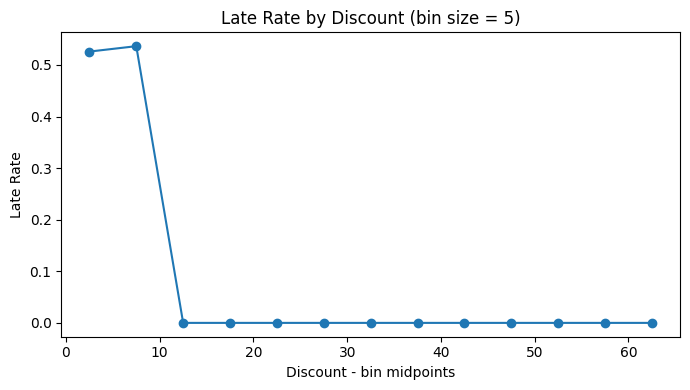

Slope (late vs discount): -0.006414


,discount_bin,records,late_rate
0,"(-0.001, 5.0]",4157,0.525860
1,"(5.0, 10.0]",4195,0.536353
2,"(10.0, 15.0]",252,0.000000
3,"(15.0, 20.0]",244,0.000000
4,"(20.0, 25.0]",230,0.000000


In [27]:
# 7) Late Rate vs Discount (Line, bins of 5)
assert "discount_offered" in df.columns, "Column 'discount_offered' not found."
d = df.dropna(subset=["discount_offered"]).copy()
bin_size = 5
start = np.floor(d["discount_offered"].min() / bin_size) * bin_size
end   = np.ceil(d["discount_offered"].max() / bin_size) * bin_size
bins  = np.arange(start, end + bin_size, bin_size)

d["discount_bin"] = pd.cut(d["discount_offered"], bins=bins, include_lowest=True)
tmp2 = (d.groupby("discount_bin")["Late"]
          .agg(["size","mean"])
          .reset_index()
          .rename(columns={"size":"records","mean":"late_rate"}))

mid2 = tmp2["discount_bin"].apply(lambda b: (b.left + b.right)/2 if pd.notna(b) else np.nan)

plt.figure(figsize=(7,4))
plt.plot(mid2, tmp2["late_rate"], marker="o")
plt.title("Late Rate by Discount (bin size = 5)")
plt.xlabel("Discount - bin midpoints")
plt.ylabel("Late Rate")
plt.tight_layout()
plt.show()

A = np.vstack([mid2.values, np.ones(len(mid2))]).T
m2, c2 = np.linalg.lstsq(A, tmp2["late_rate"].values, rcond=None)[0]
print(f"Slope (late vs discount): {m2:.6f}")
tmp2.head()

##### Summary

There is an indication of a downward trend (slope of -0.0064 per bin), so discounted orders do not exacerbate delays and may slightly accelerate them. Product/mode mix effects during promotions likely play a role; conduct further validation with variable controls (product, mode, warehouse). Recommendation: Synchronize the promotion calendar with last-mile capacity to ensure peak volumes remain on time.

#### 8. Does the number of calls to CS correlate with delays?

##### Line Chart

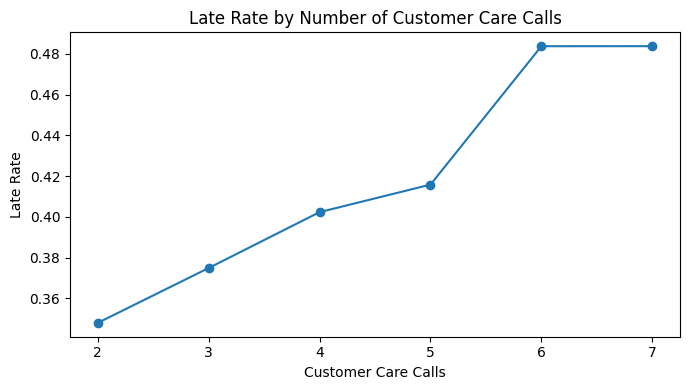

Slope (late vs calls): 0.029111


,customer_care_calls,records,late_rate
0,2,638,0.347962
1,3,3217,0.374883
2,4,3557,0.402305
3,5,2328,0.415808
4,6,1013,0.483712
5,7,246,0.483740


In [28]:
# 8) Late Rate vs Customer Care Calls (Line per hitungan integer)
assert "customer_care_calls" in df.columns, "Column 'customer_care_calls' not found."
calls = late_rate_by("customer_care_calls").sort_values("customer_care_calls")

plt.figure(figsize=(7,4))
plt.plot(calls["customer_care_calls"], calls["late_rate"], marker="o")
plt.title("Late Rate by Number of Customer Care Calls")
plt.xlabel("Customer Care Calls")
plt.ylabel("Late Rate")
plt.tight_layout()
plt.show()

# Slope tren (opsional)
A = np.vstack([calls["customer_care_calls"].values, np.ones(len(calls))]).T
m3, c3 = np.linalg.lstsq(A, calls["late_rate"].values, rcond=None)[0]
print(f"Slope (late vs calls): {m3:.6f}")
calls

##### Summary

The number of calls to customer service is positively correlated with delays (a slope of 0.0291 per additional call), making it a good leading indicator. Implement early warning: tickets with ≥2 calls are prioritized for intervention (status check, mode redirection, or rescheduling). This helps reduce late cases (FN) and improves the customer experience.

Data Scientist
===

## Feature Engineering

### Feature Creation

#### Data spliting
Split dataset into train set (learning process) & test set (testing/examining)

In [29]:
# Define X (attribute/feature) and y (target/label)
X = df.drop(columns=['reached_on_time']) # Drop y
y = df['reached_on_time']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=20
)

In [30]:
# Size
print(X_train.shape)
print(X_test.shape)

(8799, 12)
(2200, 12)


#### Cardinality Check

In [31]:
# function cardinality checker
def cardinality_check(X_train, cols):
  # code to check unique values
  raw_unique = []

  for col in cols:
    row = [col, X_train[col].nunique(), X_train[col].unique()]

    raw_unique.append(row)

  result = pd.DataFrame(raw_unique, columns=['column name', 'number of unique values', 'unique values'])

  # show data
  return result

In [32]:
# setting display
pd.set_option('max_colwidth', None)

# list of columns to be checked
list_col = X_train.columns

# check
cardinality_check(X_train, list_col)

,column name,number of unique values,unique values
0,id,8799,"[7426, 10521, 5129, 7307, 6902, 2620, 7259, 3059, 4486, 9603, 1302, 4866, 1973, 7713, 950, 10800, 5595, 9752, 6359, 7756, 5807, 9620, 30, 4757, 5596, 2678, 4128, 1000, 6323, 575, 9340, 8935, 1176, 1204, 7704, 3656, 7272, 33, 2612, 9357, 388, 6857, 1161, 6080, 2879, 2852, 4688, 9406, 8713, 5273, 3701, 6889, 6415, 3298, 6181, 7072, 6045, 976, 5855, 1215, 514, 4524, 5249, 4787, 6827, 9361, 6194, 4894, 9289, 8759, 6838, 10511, 10200, 190, 4291, 9820, 9127, 4631, 8306, 4424, 7412, 3395, 10708, 9614, 1842, 5465, 5118, 8205, 10153, 5324, 3868, 6117, 9195, 1893, 1467, 6636, 6707, 2904, 748, 665, ...]"
1,warehouse_block,5,"[B, A, C, F, D]"
2,mode_of_shipment,3,"[Ship, Flight, Road]"
3,customer_care_calls,6,"[3, 4, 6, 5, 2, 7]"
4,customer_rating,5,"[2, 4, 3, 5, 1]"
5,cost_of_the_product,215,"[214, 184, 271, 181, 266, 151, 252, 147, 215, 155, 247, 261, 243, 269, 258, 245, 220, 212, 272, 250, 208, 117, 183, 265, 113, 168, 176, 276, 175, 268, 263, 257, 191, 223, 221, 287, 173, 127, 167, 224, 207, 236, 309, 133, 286, 205, 235, 198, 249, 270, 170, 229, 248, 244, 241, 141, 195, 134, 211, 109, 140, 230, 254, 262, 256, 136, 283, 163, 274, 238, 218, 192, 186, 182, 177, 197, 185, 281, 255, 130, 189, 231, 233, 190, 304, 219, 111, 144, 148, 301, 138, 158, 260, 143, 179, 237, 194, 153, 169, 222, ...]"
6,prior_purchases,8,"[2, 3, 4, 6, 7, 5, 8, 10]"
7,product_importance,3,"[medium, high, low]"
8,gender,2,"[M, F]"
9,discount_offered,65,"[7, 9, 3, 4, 6, 30, 2, 18, 5, 55, 19, 53, 1, 36, 50, 15, 54, 25, 47, 22, 14, 8, 39, 63, 10, 12, 42, 57, 34, 11, 64, 61, 29, 60, 33, 13, 56, 43, 52, 20, 16, 65, 59, 62, 51, 38, 41, 35, 48, 32, 17, 37, 27, 23, 26, 44, 24, 28, 31, 46, 58, 49, 21, 40, 45]"


##### Display List of Columns from The Highest Cardinality

In [33]:
# calculate the number of unique values for each column
unique_counts = X_train.nunique().sort_values(ascending=False)

print("Top columns with highest cardinality:\n")
display(unique_counts)

Top columns with highest cardinality:



id                     8799
weight_in_gms          3755
cost_of_the_product     215
discount_offered         65
prior_purchases           8
customer_care_calls       6
warehouse_block           5
customer_rating           5
mode_of_shipment          3
product_importance        3
gender                    2
Late                      2
dtype: int64

##### Summary

Insight:

-  The 'id' column has the highest cardinality, with each row having a unique ID, which is expected. The 'weight_in_gms', 'cost_of_the_product', and 'discount_offered' columns also have very high cardinality, indicating diverse textual content.

- The 'gender' column has only two unique values, suggesting that all gender are listed as Male and Female. Columns like 'mode_of_shipment' and 'product_importance' have very low cardinality, indicating they are categorical variables with limited options.

Next move: 

- Drop columns
    - We are going to drop a column that identify as identity first; 'id'. Next, We are going to drop a column that We are not going to use in our model; We don't need 'Late' since it is made for EDA.

Note:

- High Cardinality for Non-Informative Columns: Columns with a very high number of unique values (like id or body text) were dropped since they don't contribute meaningfully to the analysis.

- Redundancy: When two or more columns convey similar or identical information, one or more can be dropped to avoid redundancy. This reduces multicollinearity in statistical models and simplifies the dataset. For instance, 'price' and 'price_display' both provide price information, and one is simply a formatted version of the other, one should dropped. Other examples: 'state', 'cityname', and 'address' all of them provide location information. The dataset already contains 'state', 'latitude', and 'longitude', which are precise geographical coordinates. These three columns provide a more granular and mathematically usable representation of location than cityname or address.

- Data Quality Issues: Columns with a high percentage of missing values or significant inconsistencies might be dropped if imputation is not feasible or desirable, or if the data is unreliable.

- Irrelevance: columns like 'has_photo' & 'time' don't provide any useful information for the analysis or modeling task at hand, it's best to remove it. Irrelevant columns can add noise and complexity without contributing to insights.        

##### Drop Columns

In [34]:
X_train = X_train.drop(columns=['id', 'Late'])
X_test = X_test.drop(columns=['id', 'Late'])

### Feature Transformation

#### Handling Outliers
- We are gonna handle Numerical Data only to see if we have any outliers and do we need to handle it

##### Checking Outliers

In [35]:
def outliers_checker(X_train, list_cols):
  '''

  Identify and analyze outliers in specified columns of a DataFrame.
    
  This function checks for outliers using different methods based on data distribution:

  - For normal distributions: uses mean ± 3 standard deviations
  - For skewed distributions: uses interquartile range (IQR) method
  - For extremely skewed distributions: uses extended IQR method
  - For super extremely skewed distributions: uses quantiles
  
  Parameters:
  -----------
  cl : pandas.DataFrame
               The input DataFrame containing the data to analyze

  list_cols : list
                 List of column names to check for outliers

  '''

  # empty variable
  result = []

  for col in list_cols:
    row = []

    # add column name
    row.append(col)

    # check normality
    if np.abs(X_train[col].skew()) > 1 :
      row.append('extreme skew')
    elif np.abs(X_train[col].skew()) > 0.5:
      row.append('skew')
    else:
      row.append('normal')

    # upper dan lower boundaries
    if row[1] == 'normal':
      upper = X_train[col].mean() + 3 * X_train[col].std()
      lower = X_train[col].mean() - 3 * X_train[col].std()
    elif row[1] == 'skew':
      iqr = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
      upper = X_train[col].quantile(0.75) + 1.5 * iqr
      lower = X_train[col].quantile(0.25) - 1.5 * iqr
    else:
      iqr = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
      upper = X_train[col].quantile(0.75) + 3 * iqr
      lower = X_train[col].quantile(0.25) - 3 * iqr

    # add upper and lower boundaries
    row.append(round(upper, 2))
    row.append(round(lower, 2))

    # check outliers exists or not
    if len(X_train.loc[(X_train[col]<lower) | (X_train[col]>upper)]) > 0:
      row.append('has outliers')
      row.append(round(len(X_train.loc[(X_train[col]<lower) | (X_train[col]>upper)]) / len(X_train) * 100,2))
    else:
      row.append('no outlier')
      row.append(0.0)


    result.append(row)

  result = pd.DataFrame(result, columns=['column name', 'skewness', 'upper boundary',
                                         'lower boundary', 'outliers status', 'outlier percentage (in %)'])
  return result

In [36]:
# checking distribution and upper, lower boundaries
list_cols = ['customer_care_calls', 'customer_rating', 'cost_of_the_product', 'prior_purchases', 'discount_offered', 'weight_in_gms']

# check
outliers_checker(X_train, list_cols)

,column name,skewness,upper boundary,lower boundary,outliers status,outlier percentage (in %)
0,customer_care_calls,normal,7.46,0.65,no outlier,0.00
1,customer_rating,normal,7.24,-1.26,no outlier,0.00
2,cost_of_the_product,normal,354.06,66.64,no outlier,0.00
3,prior_purchases,extreme skew,7.00,0.00,has outliers,2.72
4,discount_offered,extreme skew,28.00,-14.00,has outliers,16.17
5,weight_in_gms,normal,8543.78,-1266.06,no outlier,0.00


##### Summary

**Note: Analzying outliers**

        skew = toqerul (1.5)
        normal = Zscore = gaus = fold (3)
        extreme = toqerul (3)

**Note to handle outliers:**
- if total 'outlier percentage' > 5% use capping
    - must see the type of skewness
        - if normal use gau
        - if skew use IQR
        - if cannot use IQR for the extreme skew, it means that it is too extreme. to handling the outlier, we are going to use quantiles.
- if 'outlier percentage' < 5% use trimming

Insight:

- It looks like there are only 2 columns that have outliers. And all of them have a total percentage above 5%. Since the total outlier percentage > 5% for all numerical columns. To handle this, we are gonna use capping.

Next Moves on to handle the outlier:

- We will proceed in handling the outliers by capping all the numerical columns that have outliers.

##### Handling Outliers by Using Capping because Outlier Percentage above 5%

##### Extreme Skew

In [37]:
# Extreme skew using IQR
winsoriser_iqr = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['prior_purchases', 'discount_offered'],
                            missing_values='ignore')

X_train = winsoriser_iqr.fit_transform(X_train)
X_test = winsoriser_iqr.transform(X_test)

##### Checking outliers if it is already handled

In [38]:
# checking distribution and upper, lower boundaries
list_cols = ['customer_care_calls', 'customer_rating', 'cost_of_the_product', 'prior_purchases', 'discount_offered', 'weight_in_gms']

# check
outliers_checker(X_train, list_cols)

,column name,skewness,upper boundary,lower boundary,outliers status,outlier percentage (in %)
0,customer_care_calls,normal,7.46,0.65,no outlier,0.00
1,customer_rating,normal,7.24,-1.26,no outlier,0.00
2,cost_of_the_product,normal,354.06,66.64,no outlier,0.00
3,prior_purchases,skew,5.50,1.50,has outliers,9.14
4,discount_offered,extreme skew,28.00,-14.00,no outlier,0.00
5,weight_in_gms,normal,8543.78,-1266.06,no outlier,0.00


#### Handling Missing Value
Evaluate missing values and drop them or fill them with (mean or median or mode or make new unique values) if needed

##### Evaluate missing values

X_train

In [39]:
# check for NaN values in each columns
nan_count = X_train.isnull().sum()

print("Number of NaN values per column:")
display(nan_count)

Number of NaN values per column:


warehouse_block        0
mode_of_shipment       0
customer_care_calls    0
customer_rating        0
cost_of_the_product    0
prior_purchases        0
product_importance     0
gender                 0
discount_offered       0
weight_in_gms          0
dtype: int64

X_test

In [40]:
# check for NaN values in each columns
nan_count = X_test.isnull().sum()

print("Number of NaN values per column:")
display(nan_count)

Number of NaN values per column:


warehouse_block        0
mode_of_shipment       0
customer_care_calls    0
customer_rating        0
cost_of_the_product    0
prior_purchases        0
product_importance     0
gender                 0
discount_offered       0
weight_in_gms          0
dtype: int64

y_train

In [41]:
# check for NaN values in each columns
nan_count = y_train.isnull().sum()

print("Number of NaN values per column:")
display(nan_count)

Number of NaN values per column:


0

y_test

In [42]:
# check for NaN values in each columns
nan_count = y_test.isnull().sum()

print("Number of NaN values per column:")
display(nan_count)

Number of NaN values per column:


0

##### Insight

There are no missing values in X_train, X_test, y_train, and y_test

#### Feature Selection
- Here We are going to check the correlation between independent and dependent variables and see if all columns are needed and ready to go

##### Numerical Discrete

In [43]:
# define list cols
disc_cols = ['customer_care_calls', 'prior_purchases', 'discount_offered']

# Test statistic
result = []

for col in disc_cols:
  row = []
  corr, p_value = stats.spearmanr(X_train[col], y_train)

  # add column
  row.append(col)

  # add corr
  row.append(corr)

  # add p_value
  if p_value < 0.05:
    row.append('statistically significant')
  else:
    row.append('Not significant')

  result.append(row)


result = pd.DataFrame(result, columns=['Column Name', 'Correlation', 'Significant Status'])

result


,Column Name,Correlation,Significant Status
0,customer_care_calls,-0.064116,statistically significant
1,prior_purchases,-0.068940,statistically significant
2,discount_offered,0.333725,statistically significant


##### Numerical Continuous

In [44]:
# define list cols
conti_cols = ['cost_of_the_product', 'weight_in_gms']

# Test statistic
result = []

for col in conti_cols:
  row = []
  corr, p_value = pearsonr(X_train[col], y_train)

  # add column
  row.append(col)

  # add corr
  row.append(corr)

  # add p_value
  if p_value < 0.05:
    row.append('Statistically Significant')
  else:
    row.append('Not significant')

  result.append(row)


result = pd.DataFrame(result, columns=['Nama Kolom', 'Correlation', 'Status'])

result


,Nama Kolom,Correlation,Status
0,cost_of_the_product,-0.079041,Statistically Significant
1,weight_in_gms,-0.269603,Statistically Significant


##### Categorical Nominal

In [45]:
# define list
nom_cat_cals = ['warehouse_block', 'mode_of_shipment', 'gender']

In [46]:
# warehouse_block
A = y_train.loc[X_train[X_train['warehouse_block'].str.strip() =='A'].index]
B = y_train.loc[X_train[X_train['warehouse_block'].str.strip() =='B'].index]
C = y_train.loc[X_train[X_train['warehouse_block'].str.strip() =='C'].index]
D = y_train.loc[X_train[X_train['warehouse_block'].str.strip() =='D'].index]
F = y_train.loc[X_train[X_train['warehouse_block'].str.strip() =='F'].index]

res_1 = stats.f_oneway(A, B, C, D, F)
print('P-value:',[ 'Significant Related' if res_1.pvalue < 0.05 else 'Not Significant'])

P-value: ['Not Significant']


In [47]:
# mode_of_shipment
ship = y_train.loc[X_train[X_train['mode_of_shipment'].str.strip() =='Ship'].index]
flight = y_train.loc[X_train[X_train['mode_of_shipment'].str.strip() =='Flight'].index]
road = y_train.loc[X_train[X_train['mode_of_shipment'].str.strip() =='Road'].index]

res_2 = stats.f_oneway(ship, flight, road)
print('P-value:',[ 'Significant Related' if res_2.pvalue < 0.05 else 'Not Significant'])

P-value: ['Not Significant']


In [48]:
# gender
m = y_train.loc[X_train[X_train['gender'].str.strip() =='M'].index]
f = y_train.loc[X_train[X_train['gender'].str.strip() =='F'].index]

res_3 = stats.f_oneway(m, f)
print('P-value:',[ 'Significant Related' if res_3.pvalue < 0.05 else 'Not Significant'])

P-value: ['Not Significant']


##### Categorical Ordinal


In [49]:
# Kendall mapping for product_importance
importance_map = X_train['product_importance'].map({
    'low': 1,
    'medium': 2,
    'high': 3
})

# Kendall Tau correlation test for product_importance
corr_tau_importance, pval_importance = stats.kendalltau(importance_map, y_train)
print('Product Importance:')
print('P-value:', 'Significantly Related' if pval_importance < 0.05 else 'Not Significant')
print(f"Kendall's Tau: {corr_tau_importance:.3f}\n")

# Kendall Tau correlation test for customer_rating (already numeric, no mapping needed)
corr_tau_rating, pval_rating = stats.kendalltau(X_train['customer_rating'], y_train)
print('Customer Rating:')
print('P-value:', 'Significantly Related' if pval_rating < 0.05 else 'Not Significant')
print(f"Kendall's Tau: {corr_tau_rating:.3f}")

Product Importance:
P-value: Significantly Related
Kendall's Tau: 0.021

Customer Rating:
P-value: Not Significant
Kendall's Tau: 0.013


##### Conclusion 

Since 'warehouse_block', 'mode_of_shipment', 'gender' and 'customer_rating' is not significant, We are not going to use it in our Pipeline

### Pipeline Scaling & Encoding

- Here We are going to make a pipeline for scaling and encoding

In [50]:
# get Numerical Columns and Categorical Columns
num_columns = ['customer_care_calls', 'prior_purchases', 'discount_offered', 'cost_of_the_product', 'weight_in_gms']
ord_cat_columns = ['product_importance']

print('Numerical Columns : ', num_columns)
print('Categorical Ordinal Columns : ', ord_cat_columns)

Numerical Columns :  ['customer_care_calls', 'prior_purchases', 'discount_offered', 'cost_of_the_product', 'weight_in_gms']
Categorical Ordinal Columns :  ['product_importance']


#### Create Pipeline

In [51]:
# pipeline numerical data
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_ord_pipeline = Pipeline([
    ('Ordinal encoder', OrdinalEncoder(categories=[['low', 'medium', 'high']]))

])

preprocessing = ColumnTransformer([
    ('pipe_num', num_pipeline, num_columns),
    ('pipe_cat_ord', cat_ord_pipeline, ord_cat_columns)
])

preprocessing

,transformers,"[('pipe_num', ...), ('pipe_cat_ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


Model Definition
===

1 = Delayed (positive class)

0 = On-time (negative class)

## Logistic Regression

In [52]:
logistic = Pipeline([
    ('Preprocessor', preprocessing),
    ('knn', LogisticRegression(class_weight='balanced', random_state=42))
])

logistic

,steps,"[('Preprocessor', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipe_num', ...), ('pipe_cat_ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Training & Predicting

In [53]:
# train the model
logistic.fit(X_train, y_train)

# make predictions on both train and test sets
y_train_pred = logistic.predict(X_train)
y_train_probs = logistic.predict_proba(X_train)[:, 1]  # probabilities for class 1 (delayed)

y_test_pred = logistic.predict(X_test)
y_test_probs = logistic.predict_proba(X_test)[:, 1]  # probabilities for class 1 (delayed)

### Model Evaluation

In [54]:
print("\nLogistic Regression Model Evaluation (1 = Delayed, 0 = On-time):")
print("=======================================================")

# training set evaluation
print("\nTRAINING SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

# 3. ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_train_probs)
print(f"\nROC-AUC Score: {roc_auc_train:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_train = recall_score(y_train, y_train_pred, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_train:.2%} of actual delays caught")

# test set evaluation
print("\n\nTEST SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# 3. ROC-AUC
roc_auc_test = roc_auc_score(y_test, y_test_probs)
print(f"\nROC-AUC Score: {roc_auc_test:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_test = recall_score(y_test, y_test_pred, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_test:.2%} of actual delays caught")


Logistic Regression Model Evaluation (1 = Delayed, 0 = On-time):

TRAINING SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[2893  658]
 [2398 2850]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.81      0.65      3551
           1       0.81      0.54      0.65      5248

    accuracy                           0.65      8799
   macro avg       0.68      0.68      0.65      8799
weighted avg       0.71      0.65      0.65      8799


ROC-AUC Score: 0.7212 (0.5 = random, 1.0 = perfect)

Business-Specific Metrics (Delays = 1):
Recall (Delays): 54.31% of actual delays caught


TEST SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[717 168]
 [623 692]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.81      0.64       885
           1       0.80      0.53      0.64      1315

  

- Recall on delays is low (54%), the model catches only about half of the late shipments. Concretely: TP=2,850 of 5,248 actual delays, so 46% (FN=2,398) of true delays are missed, which is risky for SLA monitoring and proactive intervention.

- AUC 0.72 implies separability exists, with threshold tuning you can trade precision for higher recall. The current 0.5 cutoff is likely sub-optimal for the business goal of detecting delays.

- At current recall (52.6%), many late shipments won’t be flagged early enough for remediation, limiting the value of downstream playbooks (expedite, reroute, CS outreach).

## Random Forest Classifier

In [55]:
random = Pipeline([
    ('Preprocessor', preprocessing),
    ('random', RandomForestClassifier(
        class_weight="balanced", 
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    ))
])

random

,steps,"[('Preprocessor', ...), ('random', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipe_num', ...), ('pipe_cat_ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Training & Predicting

In [56]:
# train
random.fit(X_train, y_train)

y_train_pred_ran = random.predict(X_train)
y_train_probs_ran = random.predict_proba(X_train)[:, 1]  # probabilities for class 1 (delayed)

y_test_pred_ran = random.predict(X_test)
y_test_probs_ran = random.predict_proba(X_test)[:, 1]  # probabilities for class 1 (delayed)

### Model Evaluation

In [57]:
print("\nRandom Forest Model Evaluation (1 = Delayed, 0 = On-time):")
print("=======================================================")

# training set evaluation
print("\nTRAINING SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_ran))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_ran))

# 3. ROC-AUC
roc_auc_train_ran = roc_auc_score(y_train, y_train_probs_ran)
print(f"\nROC-AUC Score: {roc_auc_train_ran:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_train_ran = recall_score(y_train, y_train_pred_ran, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_train_ran:.2%} of actual delays caught")

# test set evaluation
print("\n\nTEST SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_ran))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_ran))

# 3. ROC-AUC
roc_auc_test_ran = roc_auc_score(y_test, y_test_probs_ran)
print(f"\nROC-AUC Score: {roc_auc_test_ran:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_test_ran = recall_score(y_test, y_test_pred_ran, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_test_ran:.2%} of actual delays caught")


Random Forest Model Evaluation (1 = Delayed, 0 = On-time):

TRAINING SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[3551    0]
 [   0 5248]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3551
           1       1.00      1.00      1.00      5248

    accuracy                           1.00      8799
   macro avg       1.00      1.00      1.00      8799
weighted avg       1.00      1.00      1.00      8799


ROC-AUC Score: 1.0000 (0.5 = random, 1.0 = perfect)

Business-Specific Metrics (Delays = 1):
Recall (Delays): 100.00% of actual delays caught


TEST SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[572 313]
 [399 916]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       885
           1       0.75      0.70      0.72      1315

    acc

- Recall=1.00, ROC-AUC=1.000: This indicates severe overfitting or potential leakage, the model memorizes training patterns rather than learning generalizable signals. Double-check that no target or near-target features leak into training.

- Held-out performance is only moderate (ROC-AUC 0.747): The model separates delays from on-time shipments better than chance and better than the Logistic baseline (0.72), but it’s still far from strong discrimination.

- Recall on delays 69.66%: This improves materially over Logistic Regression (53–54%) but still misses 30% of true delays, which may be unacceptable for SLA risk detection.

## Extreme Gradient Classifier

In [58]:
xgbc = Pipeline([
    ('Preprocessor', preprocessing),
    ('extreme gradient classifier', XGBClassifier(
        objective="binary:logistic", 
        eval_metric="logloss", 
        random_state=42,
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1)  # handle class imbalance (if delays are minority)
    ))
])

xgbc

,steps,"[('Preprocessor', ...), ('extreme gradient classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipe_num', ...), ('pipe_cat_ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Training & Predicting

In [59]:
# train
xgbc.fit(X_train, y_train)

# make predictions
y_train_pred_xgbc = xgbc.predict(X_train)
y_train_probs_xgbc = xgbc.predict_proba(X_train)[:, 1]  # probabilities for class 1 (delayed)

y_test_pred_xgbc = xgbc.predict(X_test)
y_test_probs_xgbc = xgbc.predict_proba(X_test)[:, 1]  # probabilities for class 1 (delayed)

### Model Evaluation

In [60]:
print("\nXGBoost Classifier Model Evaluation (1 = Delayed, 0 = On-time):")
print("============================================================")

# training set evaluation
print("\nTRAINING SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_xgbc))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_xgbc))

# 3. ROC-AUC
roc_auc_train_xgbc = roc_auc_score(y_train, y_train_probs_xgbc)
print(f"\nROC-AUC Score: {roc_auc_train_xgbc:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_train_xgbc = recall_score(y_train, y_train_pred_xgbc, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_train_xgbc:.2%} of actual delays caught")

# test set evaluation
print("\n\nTEST SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_xgbc))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_xgbc))

# 3. ROC-AUC
roc_auc_test_xgbc = roc_auc_score(y_test, y_test_probs_xgbc)
print(f"\nROC-AUC Score: {roc_auc_test_xgbc:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_test_xgbc = recall_score(y_test, y_test_pred_xgbc, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_test_xgbc:.2%} of actual delays caught")


XGBoost Classifier Model Evaluation (1 = Delayed, 0 = On-time):

TRAINING SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[3474   77]
 [1380 3868]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      3551
           1       0.98      0.74      0.84      5248

    accuracy                           0.83      8799
   macro avg       0.85      0.86      0.83      8799
weighted avg       0.87      0.83      0.84      8799


ROC-AUC Score: 0.9550 (0.5 = random, 1.0 = perfect)

Business-Specific Metrics (Delays = 1):
Recall (Delays): 73.70% of actual delays caught


TEST SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[701 184]
 [531 784]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.79      0.66       885
           1       0.81      0.60      0.69      1315

   

- Train vs. test gap: Training looks very strong (ROC-AUC = 0.955, delay recall 0.74), but held-out performance drops to ROC-AUC 0.738 with delay recall 59.62%. This indicates overfitting and/or a sub-optimal threshold for your business goal (catching delays).

- Current operating point is conservative: On train, class-1 precision is 0.98 with recall 0.74, signaling the model is cautious about flagging delays. On test, that caution translates into many missed delays (FN high).

- Comparative read: At the default threshold, XGBoost’s ROC-AUC (0.738) is similar to Random Forest (0.75) and above Logistic (0.72), but its recall (59.6%) trails your Random Forest (69.7%). So the ranking power is there, but your thresholding favors precision over recall.

- With recall 60%, 4 in 10 delayed shipments aren’t flagged early, which weakens SLA interventions (expedite/reroute/CS outreach).

## SVM

In [61]:
svc = Pipeline([
    ('Preprocessor', preprocessing),
    ('classifier', SVC(random_state=42, probability=True))
])

svc

,steps,"[('Preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipe_num', ...), ('pipe_cat_ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Training & Predicting

In [62]:
# train
svc.fit(X_train, y_train)

# make predictions
y_train_pred_svc = svc.predict(X_train)
y_train_probs_svc = svc.predict_proba(X_train)[:, 1]  # probabilities for class 1 (delayed)

y_test_pred_svc = svc.predict(X_test)
y_test_probs_svc = svc.predict_proba(X_test)[:, 1]  # probabilities for class 1 (delayed)

### Model Evaluation

In [63]:
print("\nSupport Vector Classifier Model Evaluation (1 = Delayed, 0 = On-time):")
print("==================================================================")

# training set evaluation
print("\nTRAINING SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_svc))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_svc))

# 3. ROC-AUC
roc_auc_train_svc = roc_auc_score(y_train, y_train_probs_svc)
print(f"\nROC-AUC Score: {roc_auc_train_svc:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_train_svc = recall_score(y_train, y_train_pred_svc, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_train_svc:.2%} of actual delays caught")

# test set evaluation
print("\n\nTEST SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_svc))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_svc))

# 3. ROC-AUC
roc_auc_test_svc = roc_auc_score(y_test, y_test_probs_svc)
print(f"\nROC-AUC Score: {roc_auc_test_svc:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_test_svc = recall_score(y_test, y_test_pred_svc, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_test_svc:.2%} of actual delays caught")


Support Vector Classifier Model Evaluation (1 = Delayed, 0 = On-time):

TRAINING SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[3341  210]
 [2569 2679]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.94      0.71      3551
           1       0.93      0.51      0.66      5248

    accuracy                           0.68      8799
   macro avg       0.75      0.73      0.68      8799
weighted avg       0.78      0.68      0.68      8799


ROC-AUC Score: 0.7635 (0.5 = random, 1.0 = perfect)

Business-Specific Metrics (Delays = 1):
Recall (Delays): 51.05% of actual delays caught


TEST SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[818  67]
 [645 670]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.92      0.70       885
           1       0.91      0.51      0.65      13

- Delay recall is low (51% train, 50.95% test), the model misses about 1 in 2 delayed shipments, which is risky for SLA monitoring if your target recall is ≥80%. High precision for delays (0.93 train) indicates the classifier is conservative about predicting “delayed” (few positives, many missed delays).

- ROC-AUC = 0.76 (train) & 0.73 (test) shows limited separability and small train–test gap, suggesting modest overfitting but mainly a sub-optimal operating point for your business goal.

- with 50.95% delay recall, many risky orders won’t be flagged early enough for mitigation (expedite/reroute/CS outreach).

## Models Evaluation

Summary of the model evaluation results for each model:

| Metrics   | Logistic Regression | Random Forest | XGBoost | SVM
|-----------|--------|--------|--------|-------|
| Recall    | 52.6% | 69.7% | 59.6% | 50.95% |
| ROC-AUC   | 0.715 | 0.747 | 0.738 | 0.732 |




Hyperparameter Tuning
===

We are going to Hyperparameter Tuning our best model which is Random Forest Model.

## Grid Search

### Define the Parameter Grid

Note:
underscore needs to be two underscores

In [71]:
# define the parameter grid
param_grid = {
    'extreme gradient classifier__n_estimators': [100, 200],        # number of trees
    'extreme gradient classifier__max_depth': [3, 6, 9],            # tree depth
    'extreme gradient classifier__learning_rate': [0.01, 0.1, 1, 10, 100],      # learning rate
    'extreme gradient classifier__subsample': [0.8, 1.0],           # subsample ratio
    'extreme gradient classifier__colsample_bytree': [0.8, 1.0],    # feature subsample ratio
    'extreme gradient classifier__random_state': [42]
}

In [72]:
# initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgbc,
    param_grid=param_grid,
    scoring='recall',               # optimize for recall (catching delays)
    cv=5,                           # 5-fold cross-validation
    verbose=2,
    n_jobs=-1                       # parallelize computation
)

# fit on training data
grid_search.fit(X_train, y_train)

# best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END extreme gradient classifier__colsample_bytree=0.8, extreme gradient classifier__learning_rate=0.01, extreme gradient classifier__max_depth=3, extreme gradient classifier__n_estimators=100, extreme gradient classifier__random_state=42, extreme gradient classifier__subsample=0.8; total time=   0.0s
[CV] END extreme gradient classifier__colsample_bytree=0.8, extreme gradient classifier__learning_rate=0.01, extreme gradient classifier__max_depth=3, extreme gradient classifier__n_estimators=100, extreme gradient classifier__random_state=42, extreme gradient classifier__subsample=0.8; total time=   0.0s
[CV] END extreme gradient classifier__colsample_bytree=0.8, extreme gradient classifier__learning_rate=0.01, extreme gradient classifier__max_depth=3, extreme gradient classifier__n_estimators=100, extreme gradient classifier__random_state=42, extreme gradient classifier__subsample=0.8; total time=   0.0s
[CV] END extreme

In [73]:
# get the Best Hyperparameters
grid_search.best_params_

{'extreme gradient classifier__colsample_bytree': 0.8,
 'extreme gradient classifier__learning_rate': 10,
 'extreme gradient classifier__max_depth': 3,
 'extreme gradient classifier__n_estimators': 100,
 'extreme gradient classifier__random_state': 42,
 'extreme gradient classifier__subsample': 0.8}

In [67]:
# get the best estimator
best_model = grid_search.best_estimator_

### Model Evaluation

In [74]:
# Make predictions on both train and test sets
y_train_pred_tuned = best_model.predict(X_train)
y_train_probs_tuned = best_model.predict_proba(X_train)[:, 1]

y_test_pred_tuned = best_model.predict(X_test)
y_test_probs_tuned = best_model.predict_proba(X_test)[:, 1]

print("\nTuned XGBoost Model Evaluation (1 = Delayed, 0 = On-time):")
print("==============================================================")

# Training set evaluation
print("\nTRAINING SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_tuned))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_tuned))

# 3. ROC-AUC
roc_auc_train_tuned = roc_auc_score(y_train, y_train_probs_tuned)
print(f"\nROC-AUC Score: {roc_auc_train_tuned:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_train_tuned = recall_score(y_train, y_train_pred_tuned, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_train_tuned:.2%} of actual delays caught")

# Test set evaluation
print("\n\nTEST SET PERFORMANCE:")
print("-------------------------------------------------------")
# 1. confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_tuned))

# 2. precision, recall, F1 for class 1 (delayed)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_tuned))

# 3. ROC-AUC
roc_auc_test_tuned = roc_auc_score(y_test, y_test_probs_tuned)
print(f"\nROC-AUC Score: {roc_auc_test_tuned:.4f} (0.5 = random, 1.0 = perfect)")

# 4. business-critical metrics (focus on delays = class 1)
recall_delays_test_tuned = recall_score(y_test, y_test_pred_tuned, pos_label=1)
print(f"\nBusiness-Specific Metrics (Delays = 1):")
print(f"Recall (Delays): {recall_delays_test_tuned:.2%} of actual delays caught")


Tuned XGBoost Model Evaluation (1 = Delayed, 0 = On-time):

TRAINING SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[3528   23]
 [ 551 4697]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3551
           1       1.00      0.90      0.94      5248

    accuracy                           0.93      8799
   macro avg       0.93      0.94      0.93      8799
weighted avg       0.94      0.93      0.94      8799


ROC-AUC Score: 0.9947 (0.5 = random, 1.0 = perfect)

Business-Specific Metrics (Delays = 1):
Recall (Delays): 89.50% of actual delays caught


TEST SET PERFORMANCE:
-------------------------------------------------------

Confusion Matrix:
[[626 259]
 [482 833]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.71      0.63       885
           1       0.76      0.63      0.69      1315

    accu

- Recall on delays (test) = 63.35%, better than untuned XGB (59.6%), but still missing 36.7% of true delays—likely below an SLA-oriented target (e.g., ≥80–85%).

- ROC-AUC (test) = 0.7407, similar to pre-tuning (0.738), so ranking power barely improved. The gain mainly came from different decision behavior (slightly higher recall), not stronger separability.

- Train vs test gap is large (Train AUC = 0.995, Train recall = 0.90 vs Test recall = 0.63), indicates overfitting and/or sub-optimal threshold for your business objective.

### Summary

Summary of the model evaluation results for tuned and untuned XGBoost model:

| Metrics   | Before Tuning | After Tuning |
|-----------|--------|--------|
| Recall    | 0.59 | 0.63 |
| ROC-AUC   |0.738 | 0.741 |



Model Evaluation
===

### Comparison

In [69]:
def save_best_model(y_test, y_train,
                   y_pred_untuned, y_probs_untuned, model_untuned,
                   y_pred_tuned, y_probs_tuned, model_tuned,
                   filename='best_delay_model.pkl'):
    """
    Compare models and save the best one based on comprehensive evaluation
    
    Parameters:
    -----------
    y_test : array
        True labels from test set
    y_train : array
        True labels from training set (for full evaluation)
    y_pred_* : array
        Predicted labels from each model
    y_probs_* : array
        Predicted probabilities for class 1 (delayed) from each model
    model_* : sklearn model
        The trained model objects
    filename : str
        Path to save the best model
        
    Returns:
    --------
    None (saves best model to disk)
    """
    # calculate metrics for both models
    def evaluate_model(y_true, y_pred, y_probs, model_name):
        return {
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'classification_report': classification_report(y_true, y_pred, output_dict=True),
            'recall': recall_score(y_true, y_pred, pos_label=1),
            'roc_auc': roc_auc_score(y_true, y_probs),
            'feature_importances': getattr(model_untuned.named_steps.get('extreme gradient classifier'), 'feature_importances_', None)
        }

    # evaluate both models on test set
    test_metrics = {
        'untuned': evaluate_model(y_test, y_pred_untuned, y_probs_untuned, 'Untuned'),
        'tuned': evaluate_model(y_test, y_pred_tuned, y_probs_tuned, 'Tuned')
    }

    # evaluate both models on training set
    y_train_pred_untuned = model_untuned.predict(X_train)
    y_train_probs_untuned = model_untuned.predict_proba(X_train)[:, 1]
    y_train_pred_tuned = model_tuned.predict(X_train)
    y_train_probs_tuned = model_tuned.predict_proba(X_train)[:, 1]

    train_metrics = {
        'untuned': evaluate_model(y_train, y_train_pred_untuned, y_train_probs_untuned, 'Untuned'),
        'tuned': evaluate_model(y_train, y_train_pred_tuned, y_train_probs_tuned, 'Tuned')
    }

    # create the comparison dataframe
    comparison = pd.DataFrame({
        'Metric': ['Recall (Delays)', 'ROC-AUC', 'Train-Test Recall Gap'],
        'Untuned Model': [
            test_metrics['untuned']['recall'],
            test_metrics['untuned']['roc_auc'],
            train_metrics['untuned']['recall'] - test_metrics['untuned']['recall']
        ],
        'Tuned Model': [
            test_metrics['tuned']['recall'],
            test_metrics['tuned']['roc_auc'],
            train_metrics['tuned']['recall'] - test_metrics['tuned']['recall']
        ]
    })

    # calculate improvements
    comparison['Improvement'] = comparison['Tuned Model'] - comparison['Untuned Model']
    comparison['Improvement %'] = (comparison['Improvement'] / comparison['Untuned Model'].abs()) * 100

    print("\nModel Performance Comparison:")
    print("============================")
    print(comparison.round(4))

    # visualize comparison
    plt.figure(figsize=(12, 6))
    comparison.plot(
        x='Metric',
        y=['Untuned Model', 'Tuned Model'],
        kind='bar',
        title='Model Comparison Metrics'
    )
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.show()

    # decision criteria
    recall_diff = test_metrics['tuned']['recall'] - test_metrics['untuned']['recall']
    overfitting_diff = (train_metrics['tuned']['recall'] - test_metrics['tuned']['recall']) - \
                      (train_metrics['untuned']['recall'] - test_metrics['untuned']['recall'])

    if recall_diff > 0.02 or (abs(recall_diff) <= 0.02 and overfitting_diff < 0):
        best_model = model_tuned
        best_metrics = test_metrics['tuned']
        print(f"\nSelected TUNED model (Test Recall: {test_metrics['tuned']['recall']:.3f} vs Untuned: {test_metrics['untuned']['recall']:.3f})")
    else:
        best_model = model_untuned
        best_metrics = test_metrics['untuned']
        print(f"\nSelected UNTUNED model (Test Recall: {test_metrics['untuned']['recall']:.3f} vs Tuned: {test_metrics['tuned']['recall']:.3f})")
            # save the best model
    with open(filename, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Best model saved to {filename}")

    # model info
    print("\nBest Model Detailed Info:")
    print("- Model Type:", "Tuned XGBoost" if best_model == model_tuned else "Untuned XGBoost")

    if best_model == model_tuned:
        print("- Best Parameters:", grid_search.best_params_)
    else:
        print("- Parameters:", model_untuned.named_steps['extreme gradient classifier'].get_params())

    print("\nTest Set Performance:")
    print(pd.DataFrame(best_metrics['classification_report']).round(4))

Save Model
===


Model Performance Comparison:
                  Metric  Untuned Model  Tuned Model  Improvement  \
0        Recall (Delays)         0.5962       0.6335       0.0373   
1                ROC-AUC         0.7382       0.7407       0.0025   
2  Train-Test Recall Gap         0.1408       0.2615       0.1207   

   Improvement %  
0         6.2500  
1         0.3404  
2        85.6989  


<Figure size 1200x600 with 0 Axes>

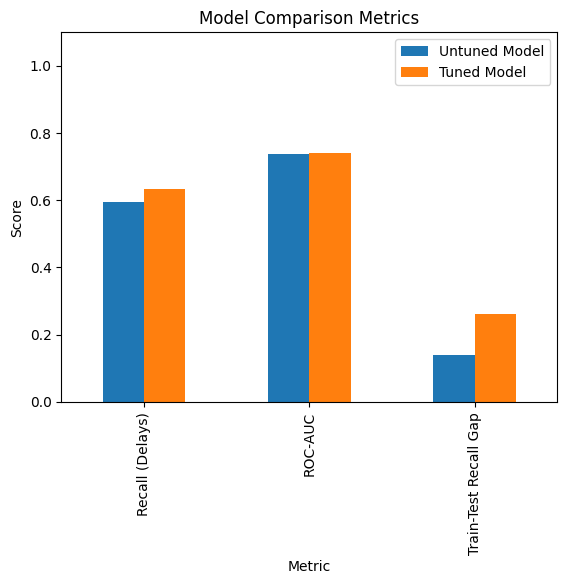


Selected TUNED model (Test Recall: 0.633 vs Untuned: 0.596)
Best model saved to best_delivery_delay_model_xgb.pkl

Best Model Detailed Info:
- Model Type: Tuned XGBoost
- Best Parameters: {'extreme gradient classifier__colsample_bytree': 1.0, 'extreme gradient classifier__learning_rate': 0.1, 'extreme gradient classifier__max_depth': 9, 'extreme gradient classifier__n_estimators': 200, 'extreme gradient classifier__random_state': 42, 'extreme gradient classifier__subsample': 0.8}

Test Set Performance:
                  0          1  accuracy  macro avg  weighted avg
precision    0.5650     0.7628    0.6632     0.6639        0.6832
recall       0.7073     0.6335    0.6632     0.6704        0.6632
f1-score     0.6282     0.6921    0.6632     0.6602        0.6664
support    885.0000  1315.0000    0.6632  2200.0000     2200.0000


In [70]:
save_best_model(
    y_test=y_test,
    y_train=y_train,
    y_pred_untuned=y_test_pred_xgbc,  # untuned XGBoost
    y_probs_untuned=y_test_probs_xgbc,
    model_untuned=xgbc,
    y_pred_tuned=y_test_pred_tuned,   # tuned XGBoost
    y_probs_tuned=y_test_probs_tuned,
    model_tuned=best_model,
    filename='best_delivery_delay_model_xgb.pkl'
)

- Recall (Delays): from 59.62% to 63.35%. That’s 4 more delayed shipments caught per 100 true delays. Good progress, but still short if the target is ≥80–85%.

- ROC-AUC: 0.7382 to 0.7407 is essentially flat. Ranking power didn’t really improve, the recall gain likely comes from changes in the operating point/fit rather than better class separation.

- Train-Test Recall Gap: 0.1408 to 0.2615 signals increased overfitting. The tuned model learned the training set much more strongly (train recall = 0.90) without translating proportionally to test recall (0.6335).